# MODEL ENGENEERING EXAM 

    ### Done By KILINDO BULAMBO Vainqueur                                               on 15.November.2022

TASK 1 : Data-Set: Credit Card Routing for Online Purchase via Predictive Modelling

## DATA DICTIONARY

#### tmsp: timestamp of transaction
#### country: country of transaction
#### amount: transaction amount
#### success: is 1 if payment is successful
#### PSP: name of payments service provider
#### 3D_secured: is 1 if customer is 3D identified (i.e. more secure online credit card payments)
#### card: credit card provider (Master, Visa, Diners)

## IMPORTING LIBRARIES

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar
sns.set_style('darkgrid')
sns.set(font_scale=1.3)  
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## LODING DATA FROM XLSX FILE

In [4]:
transaction_data = pd.read_excel('PSP_Jan_Feb_2019.xlsx')
transaction_data.head(5)

,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


## CHECKING FOR MISSING VALUES

In [5]:
transaction_data.isnull().sum()

Unnamed: 0    0
tmsp          0
country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
dtype: int64

## REMOVING UNNACESSARY COLUMNS (Unnamed:0) 

In [6]:
del transaction_data['Unnamed: 0']
transaction_data.head(5)

,tmsp,country,amount,success,PSP,3D_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [7]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tmsp        50410 non-null  datetime64[ns]
 1   country     50410 non-null  object        
 2   amount      50410 non-null  int64         
 3   success     50410 non-null  int64         
 4   PSP         50410 non-null  object        
 5   3D_secured  50410 non-null  int64         
 6   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 2.7+ MB


## FEACTURE ENGENEERING

In [8]:
transaction_data['year'] = transaction_data['tmsp'].dt.year # Extract year from tmsp column
months = []
days = []
hours = []
for i in transaction_data.index:
    
    months.append(transaction_data['tmsp'][i].strftime("%B")) # Extract month from tmsp column
    days.append(transaction_data['tmsp'][i].strftime("%A"))  # Extract weekday_name from tmsp column
    hours.append(transaction_data['tmsp'][i].strftime("%H")) # Extract hour from tmsp column
    
transaction_data['month'] = months 
transaction_data['day'] = days 
transaction_data['hour'] = hours

transaction_data.loc[transaction_data['hour'] == '00', 'hour'] = '24'
transaction_data['hour'] = transaction_data['hour'].astype(int)

''' We assume that Morning = 4 AM to 11 AM 
                   Noon = 12 PM
                   Afternoon = 1 PM to 6 PM
                   Evening = 7PM to 9 PM
                   Night = 10 PM to 11 PM and 1AM to 3AM
                   Midnight = 12 AM
'''

transaction_data.loc[(transaction_data['hour'] > 3) & (transaction_data['hour'] < 12), 'hour_cat'] = 'Morning'
transaction_data.loc[(transaction_data['hour'] == 12), 'hour_cat'] = 'Noon'
transaction_data.loc[(transaction_data['hour'] > 12) & (transaction_data['hour'] < 19),'hour_cat'] = 'Afternoon'
transaction_data.loc[(transaction_data['hour'] > 18) & (transaction_data['hour'] < 22),'hour_cat'] = 'Evening'
transaction_data.loc[(transaction_data['hour'] > 21) & (transaction_data['hour'] < 24),'hour_cat'] = 'Night'
transaction_data.loc[(transaction_data['hour'] == 24), 'hour_cat'] = 'Midnight'
transaction_data.loc[(transaction_data['hour'] < 4), 'hour_cat'] = 'Night'

In [9]:
transaction_data

,tmsp,country,amount,success,PSP,3D_secured,card,year,month,day,hour,hour_cat
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,2019,January,Tuesday,24,Midnight
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,2019,January,Tuesday,24,Midnight
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,2019,January,Tuesday,24,Midnight
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,2019,January,Tuesday,24,Midnight
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,2019,January,Tuesday,24,Midnight
...,...,...,...,...,...,...,...,...,...,...,...,...
50405,2019-02-28 23:45:39,Switzerland,415,0,UK_Card,0,Visa,2019,February,Thursday,23,Night
50406,2019-02-28 23:46:48,Austria,91,0,UK_Card,0,Master,2019,February,Thursday,23,Night
50407,2019-02-28 23:47:04,Austria,91,0,UK_Card,0,Master,2019,February,Thursday,23,Night
50408,2019-02-28 23:47:36,Austria,91,0,UK_Card,0,Master,2019,February,Thursday,23,Night


#### After extracting some features from tmsp, our dataset contains 50410 rows with 12 columns.

In [10]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tmsp        50410 non-null  datetime64[ns]
 1   country     50410 non-null  object        
 2   amount      50410 non-null  int64         
 3   success     50410 non-null  int64         
 4   PSP         50410 non-null  object        
 5   3D_secured  50410 non-null  int64         
 6   card        50410 non-null  object        
 7   year        50410 non-null  int64         
 8   month       50410 non-null  object        
 9   day         50410 non-null  object        
 10  hour        50410 non-null  int64         
 11  hour_cat    50410 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 4.6+ MB


#### There is no null value. Our dataset is constitute with 1 datetime column (tmsp), 5 numericals columns (amount,success,3D_secured,year,hour) and 6 Categoricals columns (country, PSP, card, month, day, hour_cat)

## EXPLORATIVE DATA ANALYSIS (EDA)

### 1. UNIVARIATE ANALYSIS

#### 1.1. Numerical values

purpose : we want to know the range of values present and how often these values (or groups of values) occur.

In [11]:
# Statistical summary of numerical values on our data set
transaction_data.describe()

,amount,success,3D_secured,year,hour
count,50410.000000,50410.000000,50410.000000,50410.0,50410.000000
mean,202.395715,0.202896,0.238266,2019.0,12.488197
std,96.274730,0.402160,0.426027,0.0,6.921462
min,6.000000,0.000000,0.000000,2019.0,1.000000
25%,133.000000,0.000000,0.000000,2019.0,6.000000
50%,201.000000,0.000000,0.000000,2019.0,13.000000
75%,269.000000,0.000000,0.000000,2019.0,18.000000
max,630.000000,1.000000,1.000000,2019.0,24.000000


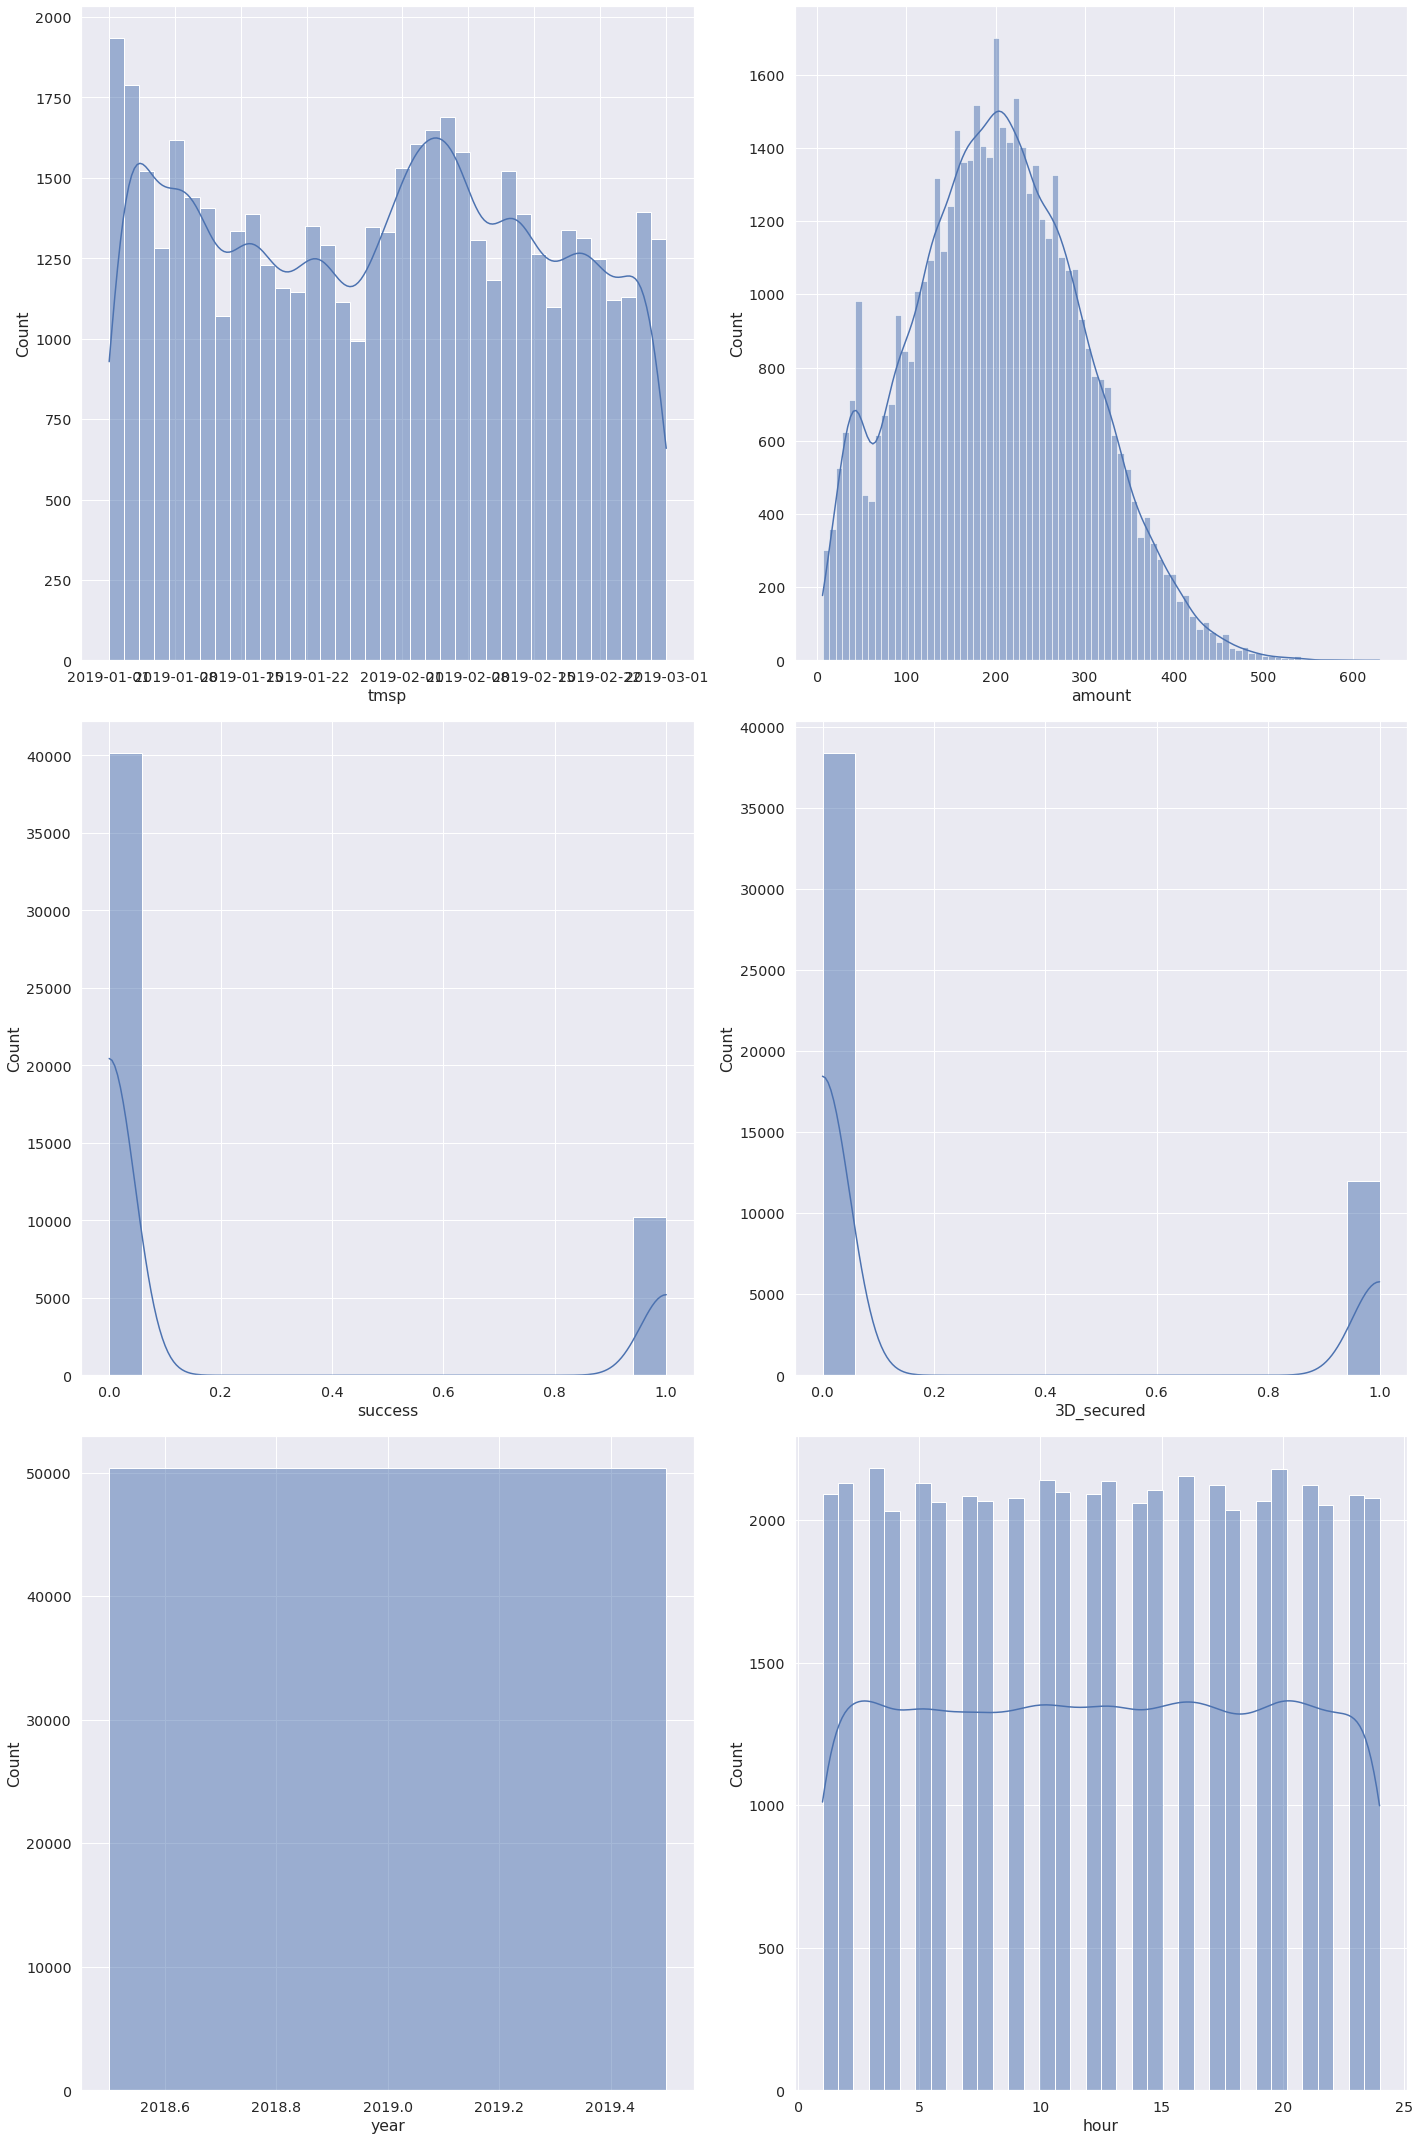

In [12]:
# Histograms to visualize data distribution

cols = 2
rows = 3
num_cols = transaction_data.select_dtypes(exclude='object').columns 
fig = plt.figure( figsize=(cols*10, rows*10)) 
for i, col in enumerate(num_cols):
    
    ax=fig.add_subplot(rows,cols,i+1)
    
    sns.histplot(x = transaction_data[col], ax = ax, kde=True)
    
fig.tight_layout()  
plt.show()

#### 1. Transaction amount varie from 6 to 630, but lot of transaction is around 200
#### 2. We can see that around a quarter of the transactions have succeeded on the totality of all the transactions carried out.
#### 3. We can see that around a third of the transactions have been made by a card with an additional security on the totality of all the transactions carried out.

### In the next phase we will analyze the relation between the target variable (success) with others variables, we will pay special attention on the relation existing between success and 3D_secured variables
     

#### 1.2. Categorical values

purpose : we want to know the number of unique classes and how frequently they occur.

In [13]:
transaction_data.describe(include='object')

,country,PSP,card,month,day,hour_cat
count,50410,50410,50410,50410,50410,50410
unique,3,4,3,2,7,6
top,Germany,UK_Card,Master,January,Tuesday,Morning
freq,30233,26459,29002,26304,8663,16701


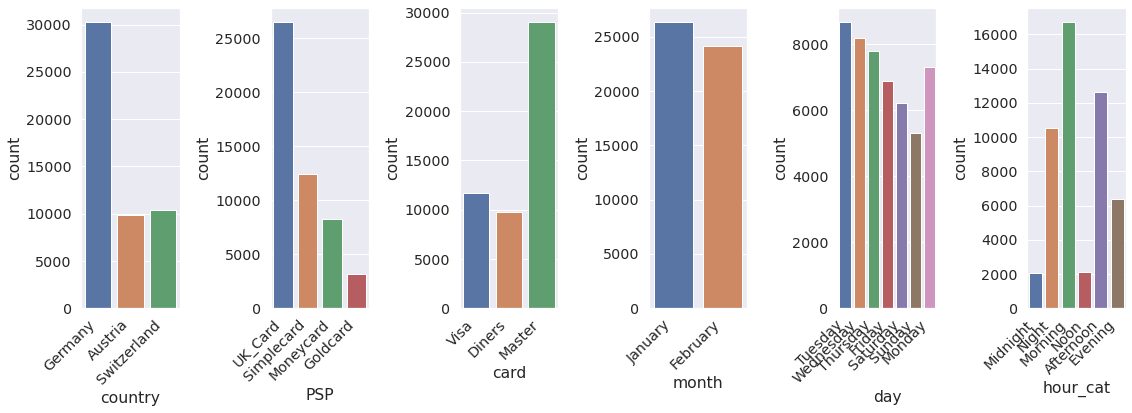

In [14]:
cols = 6
rows = 1
fig = plt.figure(figsize= (16,6))
all_categs = transaction_data.select_dtypes(include='object')
cat_cols = all_categs.columns[all_categs.nunique() < 10]
for i, col in enumerate(cat_cols):
    
    ax=fig.add_subplot(rows, cols, i+1)
    
    sns.countplot(x=transaction_data[col], ax=ax)
    
    plt.xticks(rotation=45, ha='right')
    
fig.tight_layout()  
plt.show()

#### 1. All the transactions come from three countries (Germany, Austria, Switzerland), Germany itself represents around more than half of transactions 

#### 2. All the transactions have been made by four PSPs, UK_Card itself represents around the half of transactions 

#### 3. All transactions have been made by three Card, Master itself represents around more than half of transactions 

#### 4. All transactions have been make in january and February, January has a little more transactions than February

#### 5. It looks like we have more transactions at beginning of the week than the end, as we get close to week-end transaction decrease.

#### 6. It looks like we have more transactions respectively in the morning, Afternoon,Night, Evening. Midnight and Noon have few transactions.

## BIVARIATE & MULTIVARIATE ANALYSIS

<AxesSubplot:xlabel='3D_secured', ylabel='Count'>

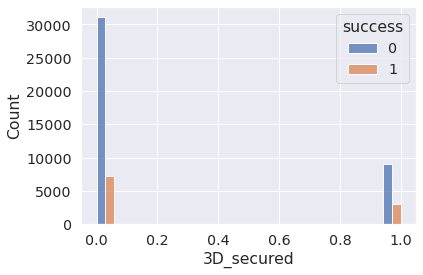

In [15]:
sns.histplot(x='3D_secured',hue='success',data=transaction_data,stat="count",multiple="dodge")

### More we have unsecured 3D_secured transactions more we have Failed transactions 

<AxesSubplot:xlabel='country', ylabel='Count'>

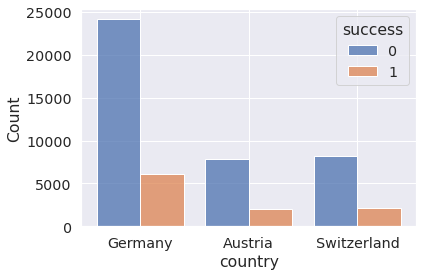

In [16]:
sns.histplot(x='country',hue='success',data=transaction_data,stat="count",multiple="dodge", shrink=.8)

<AxesSubplot:xlabel='country', ylabel='Count'>

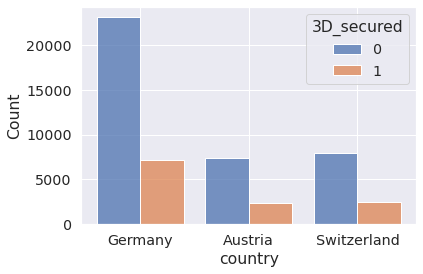

In [17]:
sns.histplot(x='country',hue='3D_secured',data=transaction_data,stat="count",multiple="dodge", shrink=.8)

<AxesSubplot:xlabel='PSP', ylabel='Count'>

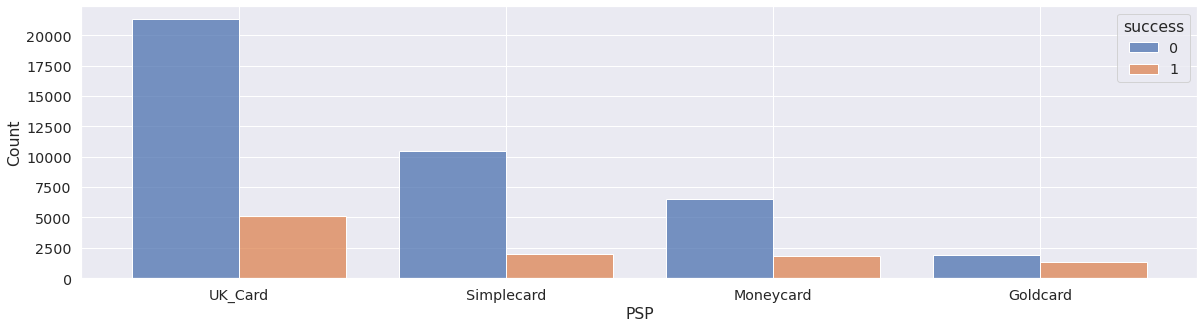

In [18]:
plt.figure(figsize=(20,5))
sns.histplot(x='PSP',hue='success',data=transaction_data,stat="count",multiple="dodge", shrink=.8)

<AxesSubplot:xlabel='PSP', ylabel='Count'>

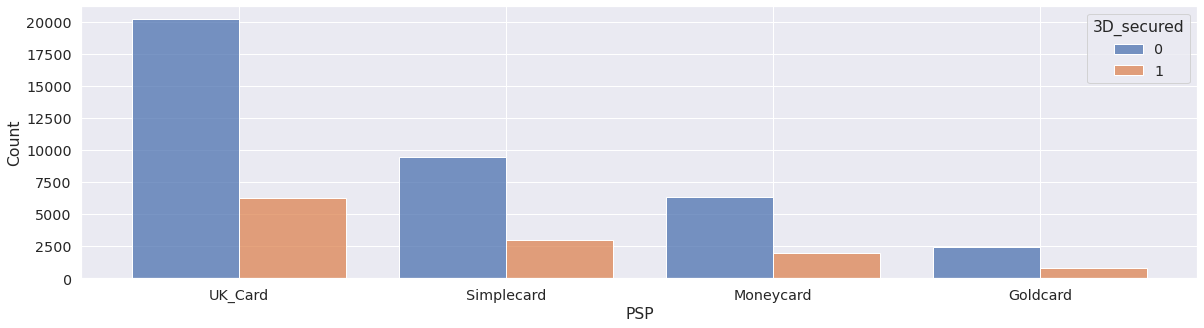

In [19]:
plt.figure(figsize=(20,5))
sns.histplot(x='PSP',hue='3D_secured',data=transaction_data,stat="count",multiple="dodge", shrink=.8)

<AxesSubplot:xlabel='hour_cat', ylabel='Count'>

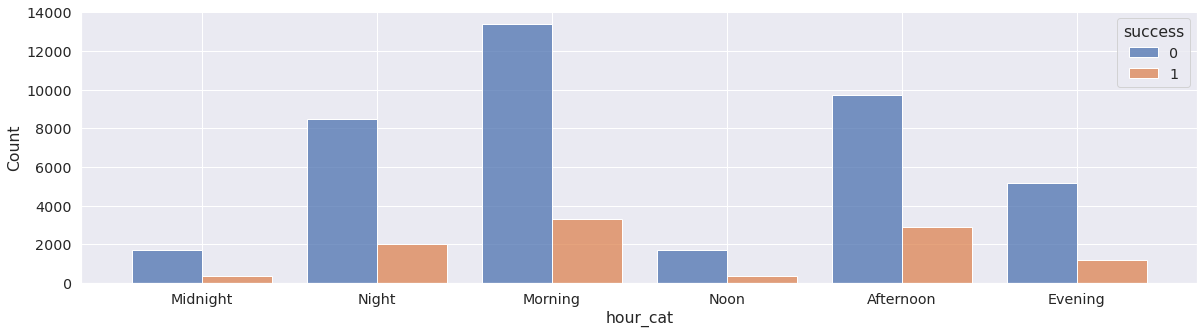

In [20]:
plt.figure(figsize=(20,5))
sns.histplot(x='hour_cat',hue='success',data=transaction_data,stat="count",multiple="dodge", shrink=.8)

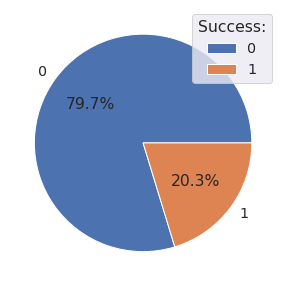

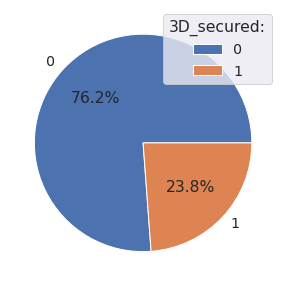

In [21]:
secured_3D = transaction_data['3D_secured'].value_counts().reset_index().rename(columns={'index':'3D_secured','3D_secured':'3D_secured_count'})

Sucess = transaction_data['success'].value_counts().reset_index().rename(columns={'index':'success','success':'success_count'})

plt.figure(figsize=(20,5))
plt.pie(Sucess['success_count'], labels = Sucess['success'], autopct='%1.1f%%')
plt.legend(title = "Success:")
plt.show()

plt.figure(figsize=(20,5))
plt.pie(secured_3D['3D_secured_count'], labels = secured_3D['3D_secured'], autopct='%1.1f%%')
plt.legend(title = "3D_secured:")
plt.show()

### To summarize our bivariate analysis, we can say that :
1. The success of thransaction depends the most on the additional security PSP and Card used for transaction.
2. We have imbalanced classes for both Sucess and 3D_secured, as many transactions have been made with non additional security PSPs, we have more Failed transactions 

## MAPPING CATEGORICAL VALUES TO NUMERICAL VALUES

In [22]:
transaction_data['country'] = transaction_data['country'].map({'Germany': 0, 'Austria': 1, 'Switzerland': 2})
transaction_data['PSP'] = transaction_data['PSP'].map({'UK_Card':0,'Simplecard':1,'Moneycard':2,'Goldcard':3})
transaction_data['card'] = transaction_data['card'].map({'Visa':0,'Diners':1,'Master':2})
transaction_data['month'] = transaction_data['month'].map({'January':0,'February':1})
transaction_data['day'] = transaction_data['day'].map({'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5,'Sunday':6})
transaction_data['hour_cat'] = transaction_data['hour_cat'].map({'Morning':0,'Noon':1,'Afternoon':2,'Evening':3,'Night':4,'Midnight':5})

## FINDING THE MUNITE AT WHICH TRANSACTION APPEND

In [23]:
minutes = []
for tmsp in transaction_data.tmsp:
    minute = int(tmsp.strftime("%M"))+(int(tmsp.strftime("%S"))/60)
    minutes.append(round(minute))
transaction_data['minute'] = minutes
transaction_data.head(10)

,tmsp,country,amount,success,PSP,3D_secured,card,year,month,day,hour,hour_cat,minute
0,2019-01-01 00:01:11,0,89,0,0,0,0,2019,0,1,24,5,1
1,2019-01-01 00:01:17,0,89,1,0,0,0,2019,0,1,24,5,1
2,2019-01-01 00:02:49,0,238,0,0,1,1,2019,0,1,24,5,3
3,2019-01-01 00:03:13,0,238,1,0,1,1,2019,0,1,24,5,3
4,2019-01-01 00:04:33,1,124,0,1,0,1,2019,0,1,24,5,5
5,2019-01-01 00:06:41,2,282,0,0,0,2,2019,0,1,24,5,7
6,2019-01-01 00:07:19,2,282,0,1,0,2,2019,0,1,24,5,7
7,2019-01-01 00:08:46,0,117,1,0,0,2,2019,0,1,24,5,9
8,2019-01-01 00:09:56,2,174,0,1,0,0,2019,0,1,24,5,10
9,2019-01-01 00:10:49,2,174,0,1,0,0,2019,0,1,24,5,11


# FILTERING DATA POINTS, FAILED TRANSACTIONS OF A CUSTOMER WITHIN ONE MINUTE

### NB: 1. We set column del=1 for all row which must be deleted.
###         2. Around 20110 rows have been deleted from the original dataset  

In [24]:
for i in transaction_data.index:
    nbre = len(transaction_data[(transaction_data['country']==transaction_data['country'][i]) &
                              (transaction_data['amount']==transaction_data['amount'][i]) &
                              (transaction_data['minute']==transaction_data['minute'][i]) &
                              (transaction_data['hour']==transaction_data['hour'][i]) &
                               (transaction_data['day']==transaction_data['day'][i]) &
                               (transaction_data['month']==transaction_data['month'][i]) &
                               (transaction_data['year']==transaction_data['year'][i])])
    
    if nbre>1:
        transaction_data.loc[(transaction_data['country']==transaction_data['country'][i]) &
                                               (transaction_data['amount']==transaction_data['amount'][i]) &
                                               (transaction_data['minute']==transaction_data['minute'][i]) & 
                                               (transaction_data['hour']==transaction_data['hour'][i]) &
                                               (transaction_data['day']==transaction_data['day'][i]) &
                                               (transaction_data['month']==transaction_data['month'][i]) &
                                               (transaction_data['year']==transaction_data['year'][i]) &
                                               (transaction_data['success']==0), 'del']=1
        
transaction_data        

,tmsp,country,amount,success,PSP,3D_secured,card,year,month,day,hour,hour_cat,minute,del
0,2019-01-01 00:01:11,0,89,0,0,0,0,2019,0,1,24,5,1,1.0
1,2019-01-01 00:01:17,0,89,1,0,0,0,2019,0,1,24,5,1,NaN
2,2019-01-01 00:02:49,0,238,0,0,1,1,2019,0,1,24,5,3,1.0
3,2019-01-01 00:03:13,0,238,1,0,1,1,2019,0,1,24,5,3,NaN
4,2019-01-01 00:04:33,1,124,0,1,0,1,2019,0,1,24,5,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50405,2019-02-28 23:45:39,2,415,0,0,0,0,2019,1,3,23,4,46,1.0
50406,2019-02-28 23:46:48,1,91,0,0,0,2,2019,1,3,23,4,47,1.0
50407,2019-02-28 23:47:04,1,91,0,0,0,2,2019,1,3,23,4,47,1.0
50408,2019-02-28 23:47:36,1,91,0,0,0,2,2019,1,3,23,4,48,1.0


In [25]:
# Delete rows having del=1
indexNames = transaction_data[ transaction_data['del'] == 1 ].index
transaction_data.drop(indexNames , inplace=True)

In [26]:
transaction_data

,tmsp,country,amount,success,PSP,3D_secured,card,year,month,day,hour,hour_cat,minute,del
1,2019-01-01 00:01:17,0,89,1,0,0,0,2019,0,1,24,5,1,NaN
3,2019-01-01 00:03:13,0,238,1,0,1,1,2019,0,1,24,5,3,NaN
4,2019-01-01 00:04:33,1,124,0,1,0,1,2019,0,1,24,5,5,NaN
7,2019-01-01 00:08:46,0,117,1,0,0,2,2019,0,1,24,5,9,NaN
8,2019-01-01 00:09:56,2,174,0,1,0,0,2019,0,1,24,5,10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50397,2019-02-28 23:31:08,2,23,1,0,0,0,2019,1,3,23,4,31,NaN
50401,2019-02-28 23:35:07,1,123,1,0,0,0,2019,1,3,23,4,35,NaN
50402,2019-02-28 23:36:08,2,242,1,0,1,1,2019,1,3,23,4,36,NaN
50403,2019-02-28 23:43:36,2,208,0,1,0,2,2019,1,3,23,4,44,NaN


In [27]:
transaction_data = transaction_data.drop('del', axis=1) # Delete column del
transaction_data

,tmsp,country,amount,success,PSP,3D_secured,card,year,month,day,hour,hour_cat,minute
1,2019-01-01 00:01:17,0,89,1,0,0,0,2019,0,1,24,5,1
3,2019-01-01 00:03:13,0,238,1,0,1,1,2019,0,1,24,5,3
4,2019-01-01 00:04:33,1,124,0,1,0,1,2019,0,1,24,5,5
7,2019-01-01 00:08:46,0,117,1,0,0,2,2019,0,1,24,5,9
8,2019-01-01 00:09:56,2,174,0,1,0,0,2019,0,1,24,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50397,2019-02-28 23:31:08,2,23,1,0,0,0,2019,1,3,23,4,31
50401,2019-02-28 23:35:07,1,123,1,0,0,0,2019,1,3,23,4,35
50402,2019-02-28 23:36:08,2,242,1,0,1,1,2019,1,3,23,4,36
50403,2019-02-28 23:43:36,2,208,0,1,0,2,2019,1,3,23,4,44


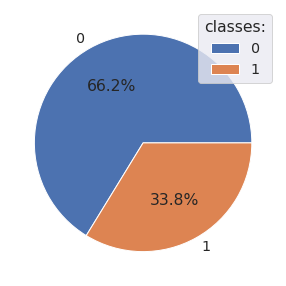

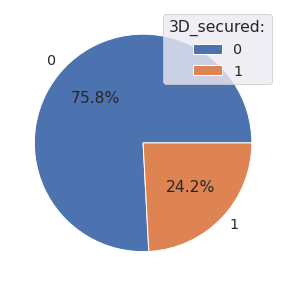

In [28]:
classes = transaction_data['success'].value_counts().reset_index().rename(columns={'index':'class','success':'success'})
secured_3D = transaction_data['3D_secured'].value_counts().reset_index().rename(columns={'index':'3D_secured','3D_secured':'3D_secured_count'})
plt.figure(figsize=(20,5))
plt.pie(classes['success'], labels = classes['class'], autopct='%1.1f%%')
plt.legend(title = "classes:")
plt.show()


plt.figure(figsize=(20,5))
plt.pie(secured_3D['3D_secured_count'], labels = secured_3D['3D_secured'], autopct='%1.1f%%')
plt.legend(title = "3D_secured:")
plt.show()

### Around 79.7% - 66.2% = 13.5 % of Failed transaction have been deleted 

After deleting some rows we still have imbalanced class

# FEATURES IMPORTANCE

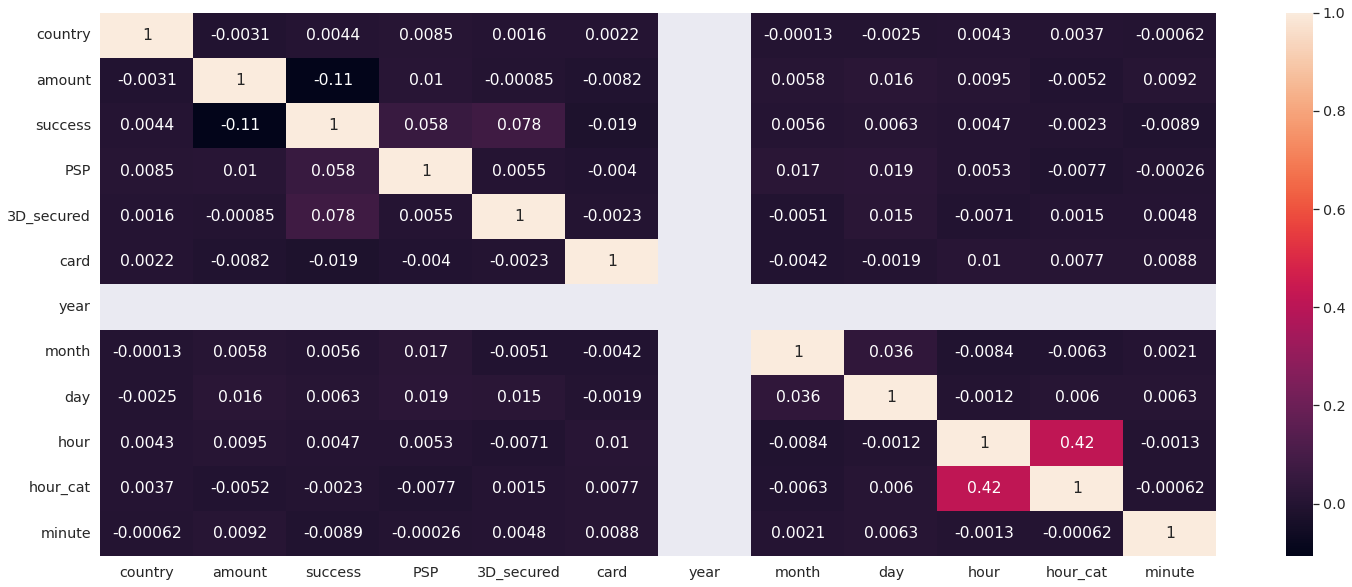

In [29]:
plt.figure(figsize=(25,10))
correlation_mat = transaction_data.corr()
sns.heatmap(correlation_mat, annot = True)
plt.show()

Feature PSP and 3D_secured are more importants, amount features. PSP and 3D_secured are positive correlated, While amount is negative correlated.Feature year has no correlation with success, means there is not relationship.

In [30]:
#Correlation with output variable
cor_target = abs(correlation_mat["success"])#Selecting highly correlated features
relevant_features = cor_target[cor_target>=0.05]
relevant_features

amount        0.106823
success       1.000000
PSP           0.058037
3D_secured    0.077880
Name: success, dtype: float64

In [31]:
# Removing some features 
redtransaction_data=transaction_data.drop(['tmsp','year','minute', 'hour_cat', 'month'], axis=1)

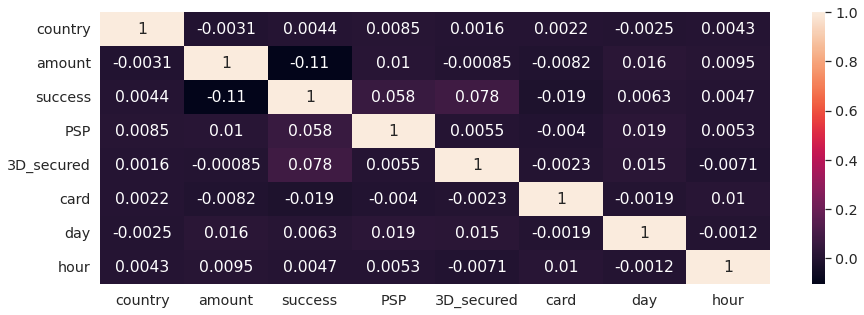

In [32]:
plt.figure(figsize=(15,5))
correlation_mat = redtransaction_data.corr()
sns.heatmap(correlation_mat, annot = True)
plt.show()

## MODELLING

In [33]:
#Modeling 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV  
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

/home/irvainqueur/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/irvainqueur/anaconda3/lib/python3.9/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# Model selection

In [34]:
def find_best_model(X_train, X_test, y_train, y_test):
    # Logistic Regression
    logreg = LogisticRegression(max_iter = 600, random_state = 42)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    logreg_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # Decision Tree
    decision_tree = DecisionTreeClassifier(random_state = 42)
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)
    decision_tree_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # Random Forest
    random_forest = RandomForestClassifier(random_state = 42)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)
    random_forest_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # XGBoost
    xgb = XGBClassifier(random_state = 42)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    xgb_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # GBM
    gbm = GradientBoostingClassifier(random_state = 42)
    gbm.fit(X_train, y_train)
    y_pred = gbm.predict(X_test)
    gbm_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # LightGBM
    lgbm = LGBMClassifier(random_state = 42)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    lgbm_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
        
    # Catboost
    catb = CatBoostClassifier(verbose = 0, random_state = 42)
    catb.fit(X_train, y_train)
    y_pred = catb.predict(X_test)
    catb_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # Histogram-based Gradient Boosting Classification Tree
    hgb = HistGradientBoostingClassifier(random_state = 42)
    hgb.fit(X_train, y_train)
    y_pred = hgb.predict(X_test)
    hgb_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    model_df = pd.DataFrame({'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'GBM', 'LightGBM', 'Catboost', 'HistBoost'],
                       'Score': [logreg_acc, decision_tree_acc, random_forest_acc, xgb_acc, gbm_acc, lgbm_acc, catb_acc, hgb_acc]})
    print(model_df.sort_values('Score', ascending = False).reset_index(drop = True))

In [35]:
# create the dataset
def get_dataset():
    #Separating inputs with label
    y = redtransaction_data['success']
    X = redtransaction_data.drop(['success'], axis=1)
    return X, y

In [36]:
X,y = get_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [37]:
find_best_model(X_train, X_test, y_train, y_test)

/home/irvainqueur/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/irvainqueur/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:43:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                 Model  Score
0            HistBoost  69.19
1             Catboost  69.11
2             LightGBM  68.47
3                  GBM  68.22
4              XGBoost  68.04
5  Logistic Regression  67.16
6        Random Forest  65.40
7        Decision Tree  60.48


### Hist Boosting algorithm is performing well than other algorithms.

In [38]:
# evaluate the model using a given test condition
def evaluate_model(cv, model):
	# get the dataset
	X, y = get_dataset()
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	# return scores
	return np.mean(scores), np.min(scores), np.max(scores)

In [39]:
# Define test condition
ideal_cv = LeaveOneOut()
# record mean and min/max of each set of results
means, mins, maxs = list(),list(),list()

for i in range(2,32):
    cv = RepeatedStratifiedKFold(n_splits=i, n_repeats=3, random_state=1)
    # get the list of models to consider
    model = HistGradientBoostingClassifier(max_bins=100,random_state = 42)
    # collect results
    ideal_results, cv_results = list(), list()
    # evaluate model using each test condition
    cv_mean, k_min, k_max = evaluate_model(cv, model)
    #ideal_mean = evaluate_model(ideal_cv, model)
    
    # store results
    cv_results.append(cv_mean)
    ideal_results.append(0.687)
    # summarize progress
    print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (i, cv_mean, k_min, k_max))
    #print('>%s: ideal=%.3f, cv=%.3f' % (type(model).__name__, ideal_mean, cv_mean))
    # store mean accuracy
    means.append(cv_mean)
    mins.append(cv_mean - k_min)
    maxs.append(k_max - cv_mean)

> folds=2, accuracy=0.682 (0.678,0.685)
> folds=3, accuracy=0.684 (0.680,0.688)
> folds=4, accuracy=0.684 (0.681,0.687)
> folds=5, accuracy=0.685 (0.678,0.691)
> folds=6, accuracy=0.684 (0.677,0.694)
> folds=7, accuracy=0.684 (0.673,0.696)
> folds=8, accuracy=0.684 (0.675,0.691)
> folds=9, accuracy=0.684 (0.676,0.695)
> folds=10, accuracy=0.684 (0.675,0.693)
> folds=11, accuracy=0.685 (0.673,0.697)
> folds=12, accuracy=0.685 (0.672,0.697)
> folds=13, accuracy=0.685 (0.672,0.695)
> folds=14, accuracy=0.684 (0.668,0.696)
> folds=15, accuracy=0.684 (0.670,0.700)
> folds=16, accuracy=0.685 (0.671,0.697)
> folds=17, accuracy=0.685 (0.669,0.699)
> folds=18, accuracy=0.684 (0.667,0.702)
> folds=19, accuracy=0.685 (0.672,0.701)
> folds=20, accuracy=0.685 (0.662,0.700)
> folds=21, accuracy=0.685 (0.667,0.703)
> folds=22, accuracy=0.685 (0.667,0.710)
> folds=23, accuracy=0.685 (0.661,0.703)
> folds=24, accuracy=0.685 (0.667,0.698)
> folds=25, accuracy=0.685 (0.661,0.703)
> folds=26, accuracy=0.6

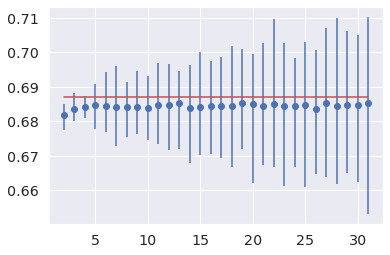

In [40]:
import matplotlib.pyplot as pyplot
ideal = 0.687
# line plot of k mean values with min/max error bars
pyplot.errorbar(range(2,32), means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
pyplot.plot(range(2,32), [ideal for _ in range(len(range(2,32)))], color='r')
# show the plot
pyplot.show()

The results suggest that for this model on this dataset, all k values underestimate the performance of the model compared to the ideal case. The results suggest that perhaps k=8,9,10,... are slightly optimistic. 
For our case will choose k=10.
Line Plot of Mean Accuracy for Cross-Validation k-Values With Error Bars (Blue) vs. the Ideal Case (red)

In [41]:
#Separating inputs with label
X, y = get_dataset()

In [42]:
#Splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=380)

In [43]:
#Fitting the model
model.fit(X_train, y_train)
#Testing the model
y_pred = model.predict(X_test)
histbar_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
histbar_acc

68.63

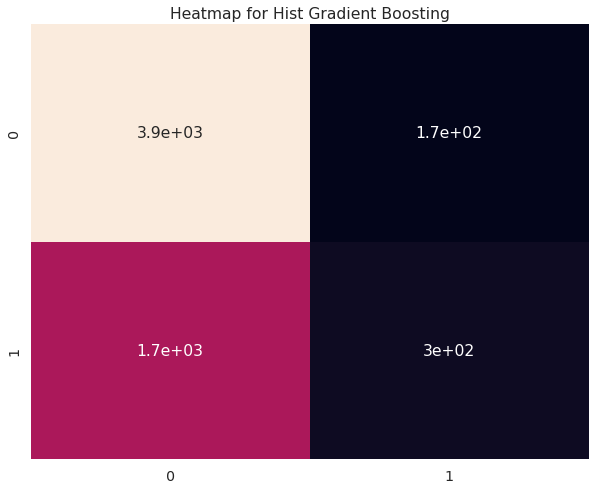

In [45]:
plt.figure(figsize=(10,8))
plt.title('Heatmap for Hist Gradient Boosting')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False)
plt.show()

In [46]:
model.classes_

array([0, 1])

In [47]:
model.predict(X_train)

array([1, 0, 0, ..., 0, 0, 1])

In [48]:
model.score(X_train, y_train)

0.694500598209497

In [49]:
model.score(X_test, y_test)

0.6863036303630363

# BUILDING A PREDICTING SYSTEM

In [52]:
from datetime import datetime

# Predicting System 
sucess_rate = pd.DataFrame(columns=['Fail','Success', 'PSP'])
PSP = [0, 1, 2, 3]
input_date = '2019-01-01 00:04:33'
datetime_object = datetime.strptime(input_date, '%Y-%m-%d %H:%M:%S')

day = datetime_object.strftime("%A")  # Extract weekday_name from tmsp column
hour = int(datetime_object.strftime("%H")) # Extract hour from tmsp column
    
if day=='Monday':
    day=1
elif day=='Tuesday':
    day=2
elif day=='Wednesday':
    day=3
elif day=='Thursday':
    day=4
elif day=='Friday':
    day=5
elif day=='Saturday':
    day=6
else:
    day=7

In [54]:
input_data = (2,355,0,1,2,0,0)
listinput_data = list(input_data)
listinput_data[5]=day
listinput_data[6]=hour

# Transaction fees

Transaction_fees = {
    'name':["Moneycard","Goldcard","UK_Card","Simplecard"],
    'successful_fee' :[5,10,3,1],
    'failed_fee':[2,5,1,0.5]
          }
df_fees = pd.DataFrame(Transaction_fees)


for i in PSP:
    # Transform the input list data to a numpy array 
    listinput_data[2]=i
    numpy_array = np.asarray(listinput_data)
    numpy_array_reshape = numpy_array.reshape(1,-1)
    prediction = model.predict_proba(numpy_array_reshape)
    
    if i==0:
        psp = 'UK_Card'
    elif i==1:
        psp = 'Simplecard'
    elif i==2:
        psp = 'Moneycard'
    elif i==3:
        psp = 'Goldcard'
    List_prediction = list(np.append(prediction,psp))
    #print(List_prediction)
    #sucess_rate=sucess_rate.append(List_prediction,ignore_index=True)
    sucess_rate = sucess_rate.append(pd.DataFrame([List_prediction],columns=["Fail","Success","PSP"]), ignore_index=True)
    
#print(sucess_rate)
#print(df_fees)

/home/irvainqueur/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/tmp/ipykernel_3725/1450700978.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sucess_rate = sucess_rate.append(pd.DataFrame([List_prediction],columns=["Fail","Success","PSP"]), ignore_index=True)
/home/irvainqueur/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/tmp/ipykernel_3725/1450700978.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sucess_rate = sucess_rate.append(pd.DataFrame([List_prediction],columns=["Fail","Success","PSP"]), ignore_index=True)


In [55]:
fee_s = []
fee_f = []
for rate in sucess_rate.index:
    for fee in df_fees.index:
        if sucess_rate['PSP'][rate] == df_fees['name'][fee]:
            fee_s.append(df_fees['successful_fee'][fee])
            fee_f.append(df_fees['failed_fee'][fee])
            

sucess_rate['sucess_fee'] = fee_s
sucess_rate['fail_fee'] = fee_f
sucess_rate

,Fail,Success,PSP,sucess_fee,fail_fee
0,0.6683946321840523,0.33160536781594774,UK_Card,3,1.0
1,0.7666132179450291,0.23338678205497093,Simplecard,1,0.5
2,0.669339955153485,0.330660044846515,Moneycard,5,2.0
3,0.3015341827709651,0.6984658172290349,Goldcard,10,5.0


#  Rule-based model.

In [94]:
def choosing_psp():
    Threshold = 0.5
    sucess_rate[['Fail', 'Success']] = sucess_rate[['Fail', 'Success']].astype(float)
    success_transactions = sucess_rate.loc[sucess_rate['Success']>=Threshold]
    fail_transactions = sucess_rate.loc[sucess_rate['Success']<Threshold]
    
    if len(success_transactions) > 0:
        minium = success_transactions['sucess_fee'].min()
        SPS = success_transactions.loc[success_transactions['sucess_fee']==minium, ['PSP','sucess_fee']]
    else:
        minium = fail_transactions['fail_fee'].min()
        SPS = fail_transactions.loc[fail_transactions['fail_fee']==minium, ['PSP','fail_fee']]
    
    print(SPS)   

In [95]:
choosing_psp()

        PSP  sucess_fee
3  Goldcard          10
